In [1]:
# !pip install safetensors \
#     nvidia-pyindex nvidia-tensorrt \
#     tritonclient[http]

In [2]:
# !pip install onnx

In [ ]:
# !pip install torchinfo

In [81]:
# --- Common Utilities and Setup ---
import os
import json
import torch
import transformers
import accelerate
import huggingface_hub
import peft
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score
from sklearn.utils import resample
from collections import Counter
import time
import onnxruntime as ort
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from typing import List
import pickle

print("peft:", peft.__version__)
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("Accelerate:", accelerate.__version__)
print("Huggingface Hub:", huggingface_hub.__version__)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

peft: 0.14.0
Torch: 2.2.2
Transformers: 4.49.0
Accelerate: 1.4.0
Huggingface Hub: 0.29.1


In [28]:
def update_model_dict(model_alias, MODEL_NAME):
    if not os.path.exists('model_dict.json'):
        model_dict = {}
    else:
        with open('model_dict.json', 'r') as file:
            model_dict = json.load(file)

    model_dict[model_alias] = MODEL_NAME

    with open('model_dict.json', 'w') as file:
        json.dump(model_dict, file)

In [29]:
filepath="./data/bitext-telco-llm-chatbot-training-dataset.csv"
df = pd.read_csv(filepath)
df.head()  

instruction           intent  \
0  there are charges on my phone bill that i do n...  dispute_invoice   
1  my internet bill is incorrect, can you help me...  dispute_invoice   
2              my invoice is not corect challenge it  dispute_invoice   
3  I don't recognize some charges on my bill, can...  dispute_invoice   
4       i have to dispute a fucking bill i need help  dispute_invoice   

  category    tags                                           response  
0  BILLING  BCELQZ  If you have noticed discrepancies in your bill...  
1  BILLING   BCILZ  If there is an issue with your bill and you wo...  
2  BILLING  BCELQZ  If you find any discrepancies in your invoice ...  
3  BILLING    BCIL  If you have found charges on your bill that yo...  
4  BILLING    BCQW  If you believe there is an error on your bill ...

In [30]:
df.head(3).to_clipboard()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
df["intent"].value_counts()

intent
dispute_invoice                        1000
invoices                               1000
check_cancellation_fee                 1000
change_provider                        1000
change_plan                            1000
cancel_plan                            1000
install_internet                       1000
deactivate_phone                       1000
deactivate_call_management_services    1000
check_signal_coverage                  1000
activate_roaming                       1000
activate_phone                         1000
activate_call_management_services      1000
schedule_payments                      1000
pay                                    1000
payment_methods                        1000
check_mobile_payments                  1000
human_agent                            1000
customer_service                       1000
set_usage_limits                       1000
check_usage                            1000
check_excess_data_charges              1000
report_problem           

In [32]:
df["category"].value_counts()


category
SERVICES        7000
SUBSCRIPTION    5000
PAYMENT         4000
COMPLAINTS      3000
CONSUMPTION     3000
BILLING         2000
CONTACT         2000
Name: count, dtype: int64

In [33]:
df[["category","intent"]].value_counts()

category      intent                             
BILLING       dispute_invoice                        1000
              invoices                               1000
SUBSCRIPTION  check_cancellation_fee                 1000
              change_provider                        1000
              change_plan                            1000
              cancel_plan                            1000
SERVICES      install_internet                       1000
              deactivate_phone                       1000
              deactivate_call_management_services    1000
              check_signal_coverage                  1000
              activate_roaming                       1000
              activate_phone                         1000
              activate_call_management_services      1000
PAYMENT       schedule_payments                      1000
              payment_methods                        1000
              pay                                    1000
              check_mo

In [34]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [35]:
def len_tokenized_input(df_col):
    tokenized_sentence = tokenizer(df_col)
    len_tokenized_sentence = len(tokenized_sentence["input_ids"])
    return len_tokenized_sentence


In [36]:
df["instruction"].apply(len_tokenized_input)


0        19
1        15
2        12
3        20
4        12
         ..
25995    11
25996    18
25997    12
25998    19
25999    13
Name: instruction, Length: 26000, dtype: int64

In [37]:
df["len_instruction"] = df["instruction"].apply(len_tokenized_input)
df["len_response"] = df["response"].apply(len_tokenized_input)

In [38]:
df.head()


instruction           intent  \
0  there are charges on my phone bill that i do n...  dispute_invoice   
1  my internet bill is incorrect, can you help me...  dispute_invoice   
2              my invoice is not corect challenge it  dispute_invoice   
3  I don't recognize some charges on my bill, can...  dispute_invoice   
4       i have to dispute a fucking bill i need help  dispute_invoice   

  category    tags                                           response  \
0  BILLING  BCELQZ  If you have noticed discrepancies in your bill...   
1  BILLING   BCILZ  If there is an issue with your bill and you wo...   
2  BILLING  BCELQZ  If you find any discrepancies in your invoice ...   
3  BILLING    BCIL  If you have found charges on your bill that yo...   
4  BILLING    BCQW  If you believe there is an error on your bill ...   

   len_instruction  len_response  
0               19           124  
1               15           124  
2               12           124  
3               20           126  
4               12           123

/var/folders/yq/ztb61z595ln533mzpd0ftylh0000gp/T/ipykernel_897/405327071.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["len_instruction"])


<Axes: xlabel='len_instruction', ylabel='Density'>

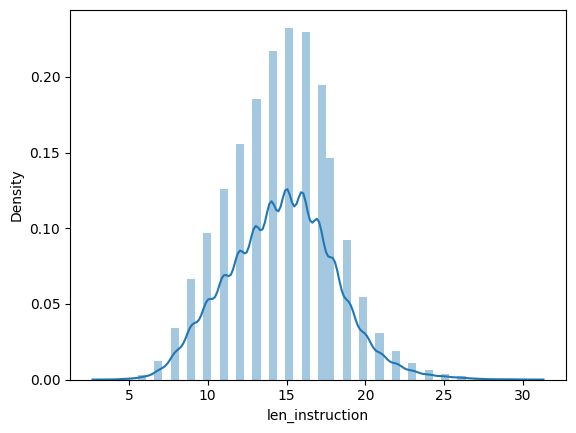

In [42]:
import seaborn as sns
sns.distplot(df["len_instruction"])

<Axes: ylabel='len_instruction'>

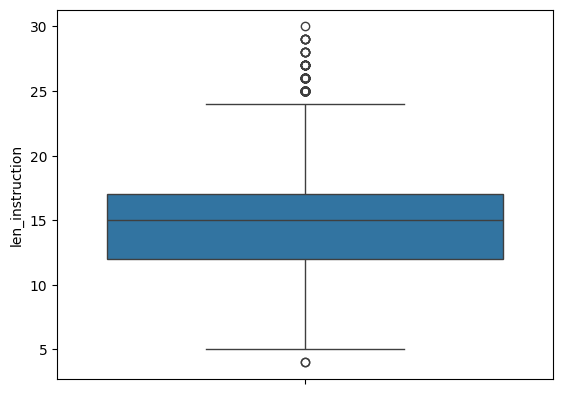

In [43]:
sns.boxplot(df["len_instruction"])


<Axes: ylabel='len_response'>

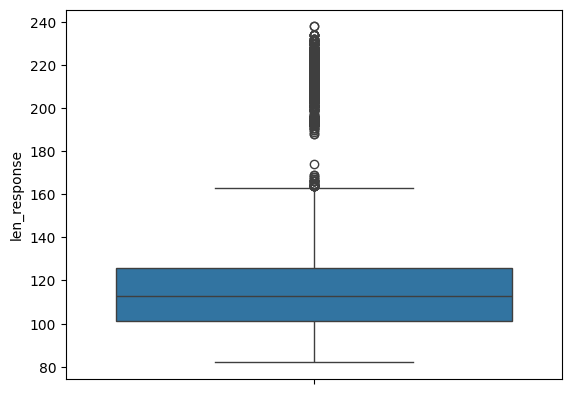

In [44]:
sns.boxplot(df["len_response"])

/var/folders/yq/ztb61z595ln533mzpd0ftylh0000gp/T/ipykernel_897/2737336791.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["len_response"])


<Axes: xlabel='len_response', ylabel='Density'>

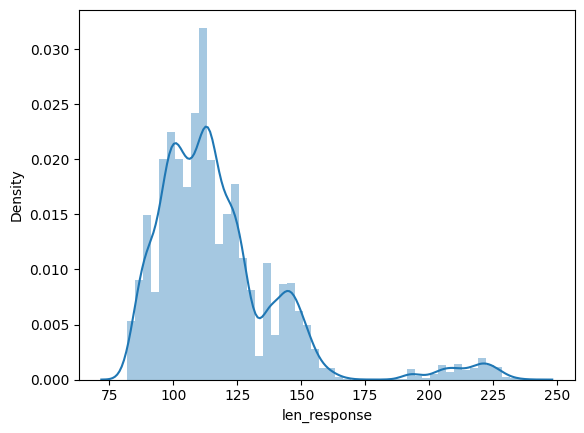

In [40]:
sns.distplot(df["len_response"])

In [7]:
for i,row_dict in df.iterrows():
    if i > 5:
        break
    else:
        print("-*"*40)
        print(f"instruction:{row_dict['instruction']}")
        print(f"response:{row_dict['response']}")
        print(f"category:{row_dict['category']}")
        print(f"intent:{row_dict['intent']}")
        print("-*"*40)


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
instruction:there are charges on my phone bill that i do not recogniae challenge it
response:If you have noticed discrepancies in your bill and wish to contest them, please adhere to the following steps:

1. Log in to your account on {{WEBSITE_URL}}.
2. Navigate to the {{INVOICE_SECTION}} section.
3. Select the bill you wish to dispute.
4. Click on the {{DISPUTE_INVOICE_OPTION}} to dispute the charge.
5. Fill in the required information and submit your dispute.

Our team will review your submission and get back to you within {{DAYS_NUMBER}} business days.
category:BILLING
intent:dispute_invoice
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
instruction:my internet bill is incorrect, can you help me dispute it ?
response:If there is an issue with your bill and you would like to formally dispute

In [47]:
label_encoder = LabelEncoder()
df["labels"] = label_encoder.fit_transform(df["category"])

In [48]:
df[['category','labels']].drop_duplicates()

category  labels
0           BILLING       0
2000     COMPLAINTS       1
5000    CONSUMPTION       2
8000        CONTACT       3
10000       PAYMENT       4
14000      SERVICES       5
21000  SUBSCRIPTION       6

In [50]:
df[['category','labels']].value_counts()

category      labels
SERVICES      5         7000
SUBSCRIPTION  6         5000
PAYMENT       4         4000
COMPLAINTS    1         3000
CONSUMPTION   2         3000
BILLING       0         2000
CONTACT       3         2000
Name: count, dtype: int64

In [51]:
def preprocess_conversation(conversation):
    """Preprocesses a conversation."""
    if isinstance(conversation, list):
        return " ".join([turn.get('instruction', '') for turn in conversation if isinstance(turn, dict)])
    return str(conversation).lower()

In [53]:
df['instruction'] = df['instruction'].apply(preprocess_conversation)

In [54]:
MODEL_NAME = "distilbert/distilbert-base-uncased"
model_alias = 'distilbert-uncased'
update_model_dict(model_alias, MODEL_NAME)

In [55]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
# train_loader, test_loader, test_df = create_dataloaders(balanced_df, tokenizer)

In [56]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [57]:
tokenizer('I love India how are you')

{'input_ids': [101, 1045, 2293, 2634, 2129, 2024, 2017, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [69]:
# Define PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=35):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        inputs = self.tokenizer(
            row["instruction"],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)
        label = torch.tensor(row["labels"], dtype=torch.long)
        return input_ids, attention_mask, label

In [70]:
batch_size=8
train_ratio=0.7
train_size = int(train_ratio * len(df))
train_size

18200

In [71]:
train_df, test_df = df[:train_size], df[train_size:]

In [72]:
train_dataset = CustomDataset(train_df, tokenizer)
test_dataset = CustomDataset(test_df, tokenizer)

In [73]:
train_dataset.__getitem__(1)

(tensor([  101,  2026,  4274,  3021,  2003, 16542,  1010,  2064,  2017,  2393,
          2033,  7593,  2009,  1029,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor(0))

In [74]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [75]:
count = 0
for dataSet in train_loader:
    count +=1
    # print(len(dataSet))

print(count)

2275


In [76]:
for batch_idx, (input_ids, attention_mask, label) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    # print(f"  Data Shape: {len(x)}")
    print(input_ids)
    print(f"  Input_ID Shape: {input_ids.shape}")
    print(label)
    print(f"  attention_mask Shape: {attention_mask.shape}")
    print(f"  Target Shape: {label.shape}") 

Batch 1:
tensor([[  101,  2026,  4274,  3021,  3475,  1005,  1056,  6149,  1010,  2052,
          2009,  2022, 13433, 18719, 16558,  2000,  7593,  2009,  1029,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1045,  2288,  2000,  2275,  2026,  8239,  2951, 21447,  1010,
          2129,  2000,  2079,  2009,  1029,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1045,  2342,  2000,  2275,  2039,  6882,  3021,  3477,  1010,
          2071,  2017,  2393,  2033,  1029,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1045,  2215,  2000, 20544,  1037,  3526,  3042,  1010,  1045,
          2342,  2393,   102,     0,     0,     0,     0,     0,  

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [77]:
print(f"Number of Batches: {len(train_loader.dataset)}")

Number of Batches: 18200


In [80]:
df['category'].nunique()

7

In [100]:
model_AutoModel = AutoModel.from_pretrained("distilbert/distilbert-base-uncased")

In [101]:
model_AutoModel

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [102]:
for i,transformer in enumerate(model_AutoModel.transformer.layer):
    print(f"Layer{i}")
    print("          ",transformer)

Layer0
           TransformerBlock(
  (attention): DistilBertSdpaAttention(
    (dropout): Dropout(p=0.1, inplace=False)
    (q_lin): Linear(in_features=768, out_features=768, bias=True)
    (k_lin): Linear(in_features=768, out_features=768, bias=True)
    (v_lin): Linear(in_features=768, out_features=768, bias=True)
    (out_lin): Linear(in_features=768, out_features=768, bias=True)
  )
  (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (ffn): FFN(
    (dropout): Dropout(p=0.1, inplace=False)
    (lin1): Linear(in_features=768, out_features=3072, bias=True)
    (lin2): Linear(in_features=3072, out_features=768, bias=True)
    (activation): GELUActivation()
  )
  (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
)
Layer1
           TransformerBlock(
  (attention): DistilBertSdpaAttention(
    (dropout): Dropout(p=0.1, inplace=False)
    (q_lin): Linear(in_features=768, out_features=768, bias=True)
    (k_lin): Linear(in_features=768, out

In [99]:
# model_simple = AutoModelForSequenceClassification.from_pretrained(
#             "distilbert/distilbert-base-uncased",
#             num_labels=6  # Ensure this matches the number of classes
#         )

In [98]:
# model_simple

In [103]:
base_model = AutoModel.from_pretrained("distilbert/distilbert-base-uncased")

In [134]:
for name,parameter in base_model.named_parameters():
    if "transformer.layer."
    print(f"Name of the layer: {name}")
    print(f"parameter.requires_grad: {parameter.requires_grad}")


Name of the layer: embeddings.word_embeddings.weight
parameter.requires_grad: True
Name of the layer: embeddings.position_embeddings.weight
parameter.requires_grad: True
Name of the layer: embeddings.LayerNorm.weight
parameter.requires_grad: True
Name of the layer: embeddings.LayerNorm.bias
parameter.requires_grad: True
Name of the layer: transformer.layer.0.attention.q_lin.weight
parameter.requires_grad: True
Name of the layer: transformer.layer.0.attention.q_lin.bias
parameter.requires_grad: True
Name of the layer: transformer.layer.0.attention.k_lin.weight
parameter.requires_grad: True
Name of the layer: transformer.layer.0.attention.k_lin.bias
parameter.requires_grad: True
Name of the layer: transformer.layer.0.attention.v_lin.weight
parameter.requires_grad: True
Name of the layer: transformer.layer.0.attention.v_lin.bias
parameter.requires_grad: True
Name of the layer: transformer.layer.0.attention.out_lin.weight
parameter.requires_grad: True
Name of the layer: transformer.layer.0

In [129]:
class CustomDistillBERT(nn.module):
    def __init__(self,tokenizer,number_label,last_number_layer):
        super(CustomDistillBERT, self).__init__()
        self.tokenizer = tokenizer
        self.number_label = number_label
        self.base_model = AutoModel.from_pretrained("distilbert/distilbert-base-uncased")

    
    def forward()

SyntaxError: expected ':' (4036605555.py, line 9)

In [130]:
from torchinfo import summary

In [95]:
summary(
    model,
    input_data={
        "input_ids": torch.randint(0, tokenizer.vocab_size, (1, 512)),
        "attention_mask": torch.ones(1, 512, dtype=torch.long)
    },
    depth=8
)

Layer (type:depth-idx)                             Output Shape              Param #
DistilBertModel                                    [1, 512, 768]             --
├─Embeddings: 1-1                                  [1, 512, 768]             --
│    └─Embedding: 2-1                              [1, 512, 768]             23,440,896
│    └─Embedding: 2-2                              [1, 512, 768]             393,216
│    └─LayerNorm: 2-3                              [1, 512, 768]             1,536
│    └─Dropout: 2-4                                [1, 512, 768]             --
├─Transformer: 1-2                                 [1, 512, 768]             --
│    └─ModuleList: 2-5                             --                        --
│    │    └─TransformerBlock: 3-1                  [1, 512, 768]             --
│    │    │    └─DistilBertSdpaAttention: 4-1      [1, 512, 768]             --
│    │    │    │    └─Linear: 5-1                  [1, 512, 768]             590,592
│    │    │   

In [46]:
66.36 *4

265.44

In [49]:
66.36*3.5

232.26

In [96]:
for i in model.named_parameters():
    print(i)

('embeddings.word_embeddings.weight', Parameter containing:
tensor([[-0.0166, -0.0666, -0.0163,  ..., -0.0200, -0.0514, -0.0264],
        [-0.0132, -0.0673, -0.0161,  ..., -0.0227, -0.0554, -0.0260],
        [-0.0176, -0.0709, -0.0144,  ..., -0.0246, -0.0596, -0.0232],
        ...,
        [-0.0231, -0.0588, -0.0105,  ..., -0.0195, -0.0262, -0.0212],
        [-0.0490, -0.0561, -0.0047,  ..., -0.0107, -0.0180, -0.0219],
        [-0.0065, -0.0915, -0.0025,  ..., -0.0151, -0.0504,  0.0460]],
       requires_grad=True))
('embeddings.position_embeddings.weight', Parameter containing:
tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
          6.8312e-04,  1.5441e-02],
        [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
          2.9753e-02, -5.3247e-03],
        [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
          1.8741e-02, -7.3140e-03],
        ...,
        [ 1.7418e-02,  3.4903e-03, -9.5621e-03,  ...,  2.9599e-03,
          4.3435e-04, -2.

In [97]:
for i in model.parameters():
    print(i)

Parameter containing:
tensor([[-0.0166, -0.0666, -0.0163,  ..., -0.0200, -0.0514, -0.0264],
        [-0.0132, -0.0673, -0.0161,  ..., -0.0227, -0.0554, -0.0260],
        [-0.0176, -0.0709, -0.0144,  ..., -0.0246, -0.0596, -0.0232],
        ...,
        [-0.0231, -0.0588, -0.0105,  ..., -0.0195, -0.0262, -0.0212],
        [-0.0490, -0.0561, -0.0047,  ..., -0.0107, -0.0180, -0.0219],
        [-0.0065, -0.0915, -0.0025,  ..., -0.0151, -0.0504,  0.0460]],
       requires_grad=True)
Parameter containing:
tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
          6.8312e-04,  1.5441e-02],
        [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
          2.9753e-02, -5.3247e-03],
        [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
          1.8741e-02, -7.3140e-03],
        ...,
        [ 1.7418e-02,  3.4903e-03, -9.5621e-03,  ...,  2.9599e-03,
          4.3435e-04, -2.6949e-02],
        [ 2.1687e-02, -6.0216e-03,  1.4736e-02,  ..., -5.6118e-03,
   

In [60]:
class DistilBERTWithLoRA(nn.Module):
    def __init__(self, num_labels, lora_r=8, lora_alpha=16, lora_dropout=0.1):
        super(DistilBERTWithLoRA, self).__init__()
        # Load the base model with the correct number of labels
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            "distilbert/distilbert-base-uncased",
            num_labels=num_labels  # Ensure this matches the number of classes
        )
        
        # LoRA Configuration
        lora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout,
            target_modules=["q_lin", "k_lin", "v_lin"]
        )
        self.bert = get_peft_model(self.bert, lora_config)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits  # Return the logits directly

In [61]:
model = DistilBERTWithLoRA(4)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
tokenizer("i love india")

{'input_ids': [101, 1045, 2293, 2634, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [135]:
summary(model,
        input_data={
        "input_ids": torch.randint(0, tokenizer.vocab_size, (1, 512)),
        "attention_mask": torch.ones(1, 512, dtype=torch.long)
    },
    depth=10
       
       
       )

Layer (type:depth-idx)                             Output Shape              Param #
DistilBertModel                                    [1, 512, 768]             --
├─Embeddings: 1-1                                  [1, 512, 768]             --
│    └─Embedding: 2-1                              [1, 512, 768]             23,440,896
│    └─Embedding: 2-2                              [1, 512, 768]             393,216
│    └─LayerNorm: 2-3                              [1, 512, 768]             1,536
│    └─Dropout: 2-4                                [1, 512, 768]             --
├─Transformer: 1-2                                 [1, 512, 768]             --
│    └─ModuleList: 2-5                             --                        --
│    │    └─TransformerBlock: 3-1                  [1, 512, 768]             --
│    │    │    └─DistilBertSdpaAttention: 4-1      [1, 512, 768]             --
│    │    │    │    └─Linear: 5-1                  [1, 512, 768]             590,592
│    │    │   

In [59]:
model

DistilBERTWithLoRA(
  (bert): PeftModelForSequenceClassification(
    (base_model): LoraModel(
      (model): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): DistilBertSdpaAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=8, bias

In [71]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# 1.1 Basic tokenization
text = "The quick brown fox jumps over the lazy dog."
tokens = tokenizer.tokenize(text)
print("Tokens:", tokens)

# 1.2 Convert tokens to IDs
ids = tokenizer.convert_tokens_to_ids(tokens)
print("IDs:", ids)

# 1.3 Full encoding with attention mask
encoding = tokenizer(text, return_tensors="pt")
print("Encoded input:", encoding)

Tokens: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']
IDs: [1996, 4248, 2829, 4419, 14523, 2058, 1996, 13971, 3899, 1012]
Encoded input: {'input_ids': tensor([[  101,  1996,  4248,  2829,  4419, 14523,  2058,  1996, 13971,  3899,
          1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [72]:
from transformers import AutoModel
import torch

model = AutoModel.from_pretrained("bert-base-uncased")

# 2.1 Get hidden states
with torch.no_grad():
    outputs = model(**encoding)
print("Last hidden state shape:", outputs.last_hidden_state.shape)

# 2.2 Get all hidden states
model = AutoModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
with torch.no_grad():
    outputs = model(**encoding)
print("Number of hidden state layers:", len(outputs.hidden_states))

Last hidden state shape: torch.Size([1, 12, 768])
Number of hidden state layers: 13


In [73]:
summary(model,
        input_data={
        "input_ids": torch.randint(0, tokenizer.vocab_size, (1, 512)),
        "attention_mask": torch.ones(1, 512, dtype=torch.long)
    },
    depth=8)

Layer (type:depth-idx)                                  Output Shape              Param #
BertModel                                               [1, 512, 768]             --
├─BertEmbeddings: 1-1                                   [1, 512, 768]             --
│    └─Embedding: 2-1                                   [1, 512, 768]             23,440,896
│    └─Embedding: 2-2                                   [1, 512, 768]             1,536
│    └─Embedding: 2-3                                   [1, 512, 768]             393,216
│    └─LayerNorm: 2-4                                   [1, 512, 768]             1,536
│    └─Dropout: 2-5                                     [1, 512, 768]             --
├─BertEncoder: 1-2                                      [1, 512, 768]             --
│    └─ModuleList: 2-6                                  --                        --
│    │    └─BertLayer: 3-1                              [1, 512, 768]             --
│    │    │    └─BertAttention: 4-1      

In [74]:
for layer_name,parameters_tensor in model.named_parameters():
    print(layer_name, parameters_tensor.requires_grad)
    parameters_tensor.requires_grad = False

embeddings.word_embeddings.weight True
embeddings.position_embeddings.weight True
embeddings.token_type_embeddings.weight True
embeddings.LayerNorm.weight True
embeddings.LayerNorm.bias True
encoder.layer.0.attention.self.query.weight True
encoder.layer.0.attention.self.query.bias True
encoder.layer.0.attention.self.key.weight True
encoder.layer.0.attention.self.key.bias True
encoder.layer.0.attention.self.value.weight True
encoder.layer.0.attention.self.value.bias True
encoder.layer.0.attention.output.dense.weight True
encoder.layer.0.attention.output.dense.bias True
encoder.layer.0.attention.output.LayerNorm.weight True
encoder.layer.0.attention.output.LayerNorm.bias True
encoder.layer.0.intermediate.dense.weight True
encoder.layer.0.intermediate.dense.bias True
encoder.layer.0.output.dense.weight True
encoder.layer.0.output.dense.bias True
encoder.layer.0.output.LayerNorm.weight True
encoder.layer.0.output.LayerNorm.bias True
encoder.layer.1.attention.self.query.weight True
encoder.

In [75]:
summary(model,
        input_data={
        "input_ids": torch.randint(0, tokenizer.vocab_size, (1, 512)),
        "attention_mask": torch.ones(1, 512, dtype=torch.long)
    },
    depth=8)

Layer (type:depth-idx)                                  Output Shape              Param #
BertModel                                               [1, 512, 768]             --
├─BertEmbeddings: 1-1                                   [1, 512, 768]             --
│    └─Embedding: 2-1                                   [1, 512, 768]             (23,440,896)
│    └─Embedding: 2-2                                   [1, 512, 768]             (1,536)
│    └─Embedding: 2-3                                   [1, 512, 768]             (393,216)
│    └─LayerNorm: 2-4                                   [1, 512, 768]             (1,536)
│    └─Dropout: 2-5                                     [1, 512, 768]             --
├─BertEncoder: 1-2                                      [1, 512, 768]             --
│    └─ModuleList: 2-6                                  --                        --
│    │    └─BertLayer: 3-1                              [1, 512, 768]             --
│    │    │    └─BertAttention: 4

In [76]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained("bert-base-uncased")
print(config)

# 3.1 Initialize model from config (random weights)
model_from_config = AutoModel.from_config(config)
print(model_from_config)

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (laye

In [78]:
# pip install accelerate
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
checkpoint = "HuggingFaceTB/SmolLM-135M"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)



In [79]:
# for fp16 use `torch_dtype=torch.float16` instead
model = AutoModelForCausalLM.from_pretrained(checkpoint)
inputs = tokenizer.encode("def print_hello_world():", return_tensors="pt")
outputs = model.generate(inputs)
print(tokenizer.decode(outputs[0]))

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


def print_hello_world():
    print("Hello World!")

# print_hello_world()

# print_


In [80]:
inputs

tensor([[ 1604,  1628,    79, 28120,    79,  6693,  3734]])

In [81]:
outputs

tensor([[ 1604,  1628,    79, 28120,    79,  6693,  3734,   472,  1628,  1470,
         19556,  2260, 24420,   198,   198,    19,  1628,    79, 28120,    79,
          6693,  1000,   198,   198,    19,  1628,    79]])

In [104]:
# Function to compute class weights
def compute_class_weights(labels, num_classes):
    counter = Counter(labels)
    total_samples = len(labels)
    weights = [total_samples / (num_classes * counter[i]) for i in range(num_classes)]
    return torch.tensor(weights, dtype=torch.float)

In [105]:
def train_model(model, train_loader, model_alias, epochs=3, learning_rate=5e-5, class_weights=None):
    """Trains the model and saves logs, metrics, and model weights."""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    # Create directory for storing model metrics
    model_dir = f"model-metric/{model_alias}"
    os.makedirs(model_dir, exist_ok=True)

    # TensorBoard writer in the model directory
    writer = SummaryWriter(log_dir=model_dir)

    # Set up loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device) if class_weights is not None else None)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    epoch_losses = []
    metrics_data = []

    for epoch in range(epochs):
        start_time = time.time()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch_idx, batch in enumerate(train_loader):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().tolist()
            labels = labels.cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels)

            # Log batch loss every 10 batches
            if batch_idx % 10 == 0:
                writer.add_scalar("BatchLoss/train", loss.item(), epoch * len(train_loader) + batch_idx)

        # Compute epoch metrics
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
        epoch_time = time.time() - start_time

        # Store metrics for CSV logging
        metrics_data.append([epoch + 1, avg_loss, accuracy, precision, recall, f1, epoch_time])

        # Print metrics
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}, Time={epoch_time:.2f}s")

        # Log metrics to TensorBoard
        writer.add_scalar("Loss/train", avg_loss, epoch)
        writer.add_scalar("Accuracy/train", accuracy, epoch)
        writer.add_scalar("Precision/train", precision, epoch)
        writer.add_scalar("Recall/train", recall, epoch)
        writer.add_scalar("F1-score/train", f1, epoch)
        writer.add_scalar("Time/Epoch", epoch_time, epoch)

    # Save model KPIs as CSV
    metrics_df = pd.DataFrame(metrics_data, columns=["Epoch", "Loss", "Accuracy", "Precision", "Recall", "F1-score", "Time (s)"])
    metrics_df.to_csv(os.path.join(model_dir, "training_metrics.csv"), index=False)

    # Save training loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    loss_plot_path = os.path.join(model_dir, "training_loss.png")
    plt.savefig(loss_plot_path)
    writer.add_figure("Training Loss", plt.gcf(), close=True)

    # Save model weights
    model_path = os.path.join(model_dir, f"{model_alias}.pth")
    torch.save(model.state_dict(), model_path)

    writer.flush()
    writer.close()


In [106]:
import os
import time
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

def evaluate_model(model, test_loader, label_encoder, model_alias):
    """Evaluates the model and saves metrics, logs, and confusion matrix."""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Create directory for storing model metrics
    model_dir = f"model-metric/{model_alias}"
    os.makedirs(model_dir, exist_ok=True)

    # Initialize TensorBoard writer
    writer = SummaryWriter(log_dir=model_dir)

    all_preds, all_labels = [], []
    start_time = time.time()

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1).cpu().tolist()
            labels = labels.cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels)

    eval_time = time.time() - start_time
    class_names = label_encoder.classes_

    # Compute metrics
    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average=None)
    class_metrics = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })

    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    # Print and save classification report
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()

    # Save confusion matrix plot
    confusion_matrix_path = os.path.join(model_dir, "confusion_matrix.png")
    plt.savefig(confusion_matrix_path)
    writer.add_figure("Confusion Matrix", plt.gcf(), close=True)

    # Print overall metrics
    print("\nPer-class Metrics:\n", class_metrics.to_string(index=False))
    print(f"\nOverall Metrics:\nPrecision: {overall_precision:.4f}, Recall: {overall_recall:.4f}, F1-score: {overall_f1:.4f}, Eval Time: {eval_time:.2f}s")

    # Log metrics to TensorBoard
    writer.add_scalar("Precision/test", overall_precision)
    writer.add_scalar("Recall/test", overall_recall)
    writer.add_scalar("F1-score/test", overall_f1)
    writer.add_scalar("Evaluation Time", eval_time)

    # Log per-class metrics
    for i, class_name in enumerate(class_names):
        writer.add_scalar(f"Precision/{class_name}", precision[i])
        writer.add_scalar(f"Recall/{class_name}", recall[i])
        writer.add_scalar(f"F1-score/{class_name}", f1[i])

    writer.flush()
    writer.close()

    # Save evaluation metrics
    class_metrics.to_csv(os.path.join(model_dir, "class_metrics.csv"), index=False)
    cm_df.to_csv(os.path.join(model_dir, "confusion_matrix.csv"))

    return class_metrics, cm_df


In [109]:
import os
import time
import torch
import numpy as np
import onnxruntime as ort
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

def export_to_onnx(model, tokenizer, model_alias):
    """Exports the model to ONNX format."""
    model.eval().to("cpu")
    sample_input = tokenizer("test", return_tensors="pt")
    input_names = ["input_ids", "attention_mask"]
    output_names = ["output"]
    
    model_dir = f"model-metric/{model_alias}"
    os.makedirs(model_dir, exist_ok=True)
    onnx_path = os.path.join(model_dir, f"{model_alias}.onnx")
    
    torch.onnx.export(
        model, 
        (sample_input["input_ids"], sample_input["attention_mask"]), 
        onnx_path, 
        input_names=input_names, 
        output_names=output_names, 
        dynamic_axes={
            "input_ids": {0: "batch", 1: "sequence"}, 
            "attention_mask": {0: "batch", 1: "sequence"}, 
            "output": {0: "batch"}
        }
    )
    print(f"ONNX model exported to {onnx_path}")
    return onnx_path

def run_onnx_inference(onnx_path, input_ids, attention_mask):
    """Runs inference using ONNX Runtime."""
    ort_session = ort.InferenceSession(onnx_path)
    ort_inputs = {"input_ids": input_ids.tolist(), "attention_mask": attention_mask.tolist()}
    ort_outputs = ort_session.run(None, ort_inputs)
    return torch.tensor(np.array(ort_outputs[0]), dtype=torch.float32)

def compare_inference_performance(model, tokenizer, test_df, label_encoder, model_alias):
    """Compares inference performance between PyTorch and ONNX Runtime."""
    model_dir = f"model-metric/{model_alias}"
    os.makedirs(model_dir, exist_ok=True)
    writer = SummaryWriter(log_dir=model_dir)
    
    sample_batch = test_df.sample(50)
    test_dataset_batch = CustomDataset(sample_batch, tokenizer)
    test_loader_batch = DataLoader(test_dataset_batch, batch_size=len(sample_batch), shuffle=False)
    batch = next(iter(test_loader_batch))
    input_ids, attention_mask, labels = batch
    
    # PyTorch Inference
    model.eval().to(device)
    start_time_torch = time.time()
    with torch.no_grad():
        torch_outputs = model(input_ids.to(device), attention_mask.to(device)).cpu()
    latency_torch = time.time() - start_time_torch
    throughput_torch = len(sample_batch) / latency_torch
    
    # ONNX Inference
    onnx_path = export_to_onnx(model, tokenizer, model_alias)
    start_time_onnx = time.time()
    onnx_outputs = run_onnx_inference(onnx_path, input_ids, attention_mask)
    latency_onnx = time.time() - start_time_onnx
    throughput_onnx = len(sample_batch) / latency_onnx
    
    print(f"PyTorch Inference - Latency: {latency_torch:.4f}s, Throughput: {throughput_torch:.2f} samples/s")
    print(f"ONNX Inference - Latency: {latency_onnx:.4f}s, Throughput: {throughput_onnx:.2f} samples/s")
    
    torch_preds = torch.argmax(torch_outputs, dim=1).tolist()
    onnx_preds = torch.argmax(onnx_outputs, dim=1).tolist()
    actual_labels = labels.tolist()
    
    # Compare predictions
    torch_report = classification_report(actual_labels, torch_preds, target_names=label_encoder.classes_, output_dict=True)
    onnx_report = classification_report(actual_labels, onnx_preds, target_names=label_encoder.classes_, output_dict=True)
    
    torch_df = pd.DataFrame(torch_report).transpose()
    onnx_df = pd.DataFrame(onnx_report).transpose()
    
    torch_df.to_csv(os.path.join(model_dir, "torch_classification_report.csv"))
    onnx_df.to_csv(os.path.join(model_dir, "onnx_classification_report.csv"))
    
    # Log metrics to TensorBoard
    writer.add_scalar("Latency/PyTorch", latency_torch)
    writer.add_scalar("Throughput/PyTorch", throughput_torch)
    writer.add_scalar("Latency/ONNX", latency_onnx)
    writer.add_scalar("Throughput/ONNX", throughput_onnx)
    
    writer.flush()
    writer.close()
    
    return torch_df, onnx_df


In [110]:
def compute_class_weights(labels, num_classes):
    counter = Counter(labels)
    total_samples = len(labels)
    weights = [total_samples / (num_classes * counter[i]) for i in range(num_classes)]
    return torch.tensor(weights, dtype=torch.float)

In [113]:
df, label_encoder = load_and_preprocess_data()
balanced_df = balance_dataset(df)
balanced_df['conversation'] = balanced_df['conversation'].apply(preprocess_conversation)

Original distribution:
 issue_area
Cancellations and returns    286
Order                        270
Login and Account            151
Shopping                     116
Warranty                     105
Shipping                      72
Name: count, dtype: int64


In [114]:
MODEL_NAME = "distilbert/distilbert-base-uncased"
model_alias = 'distilbert-uncased'
update_model_dict(model_alias, MODEL_NAME)

In [115]:
    # Tokenization and DataLoaders
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
train_loader, test_loader, test_df = create_dataloaders(balanced_df, tokenizer)

In [116]:
# Model Initialization and Training
num_classes = len(label_encoder.classes_)
model = DistilBERTWithLoRA(num_labels=num_classes)
class_weights = compute_class_weights(balanced_df['labels'], num_classes)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [118]:
train_model(model, train_loader,model_alias='distilbert-uncased', epochs=10, learning_rate=5e-5, class_weights=class_weights)

Epoch 1: Loss=1.7881, Accuracy=0.2156, Precision=0.2954, Recall=0.2156, F1-score=0.1571, Time=158.84s
Epoch 2: Loss=1.7118, Accuracy=0.3822, Precision=0.4671, Recall=0.3822, F1-score=0.3583, Time=154.48s
Epoch 3: Loss=1.3134, Accuracy=0.6600, Precision=0.6502, Recall=0.6600, F1-score=0.6094, Time=143.74s
Epoch 4: Loss=0.7909, Accuracy=0.7711, Precision=0.7626, Recall=0.7711, F1-score=0.7485, Time=146.47s
Epoch 5: Loss=0.5527, Accuracy=0.8444, Precision=0.8450, Recall=0.8444, F1-score=0.8390, Time=150.26s
Epoch 6: Loss=0.4400, Accuracy=0.8756, Precision=0.8768, Recall=0.8756, F1-score=0.8708, Time=161.69s
Epoch 7: Loss=0.3599, Accuracy=0.8933, Precision=0.8935, Recall=0.8933, F1-score=0.8920, Time=153.17s
Epoch 8: Loss=0.3110, Accuracy=0.9200, Precision=0.9208, Recall=0.9200, F1-score=0.9188, Time=150.76s
Epoch 9: Loss=0.2625, Accuracy=0.9267, Precision=0.9283, Recall=0.9267, F1-score=0.9252, Time=149.00s
Epoch 10: Loss=0.2321, Accuracy=0.9356, Precision=0.9374, Recall=0.9356, F1-score=

In [119]:
# Model Evaluation
evaluate_model(model, test_loader, label_encoder, model_alias)


Classification Report:
                            precision    recall  f1-score   support

Cancellations and returns       0.83      0.95      0.88        20
        Login and Account       1.00      1.00      1.00        28
                    Order       0.92      0.80      0.86        30
                 Shipping       0.85      1.00      0.92        23
                 Shopping       1.00      0.86      0.93        22
                 Warranty       1.00      1.00      1.00        27

                 accuracy                           0.93       150
                macro avg       0.93      0.94      0.93       150
             weighted avg       0.94      0.93      0.93       150


Per-class Metrics:
                     Class  Precision   Recall  F1-Score  Support
Cancellations and returns   0.826087 0.950000  0.883721       20
        Login and Account   1.000000 1.000000  1.000000       28
                    Order   0.923077 0.800000  0.857143       30
                 Ship

(                       Class  Precision    Recall  F1-Score  Support
 0  Cancellations and returns   0.826087  0.950000  0.883721       20
 1          Login and Account   1.000000  1.000000  1.000000       28
 2                      Order   0.923077  0.800000  0.857143       30
 3                   Shipping   0.851852  1.000000  0.920000       23
 4                   Shopping   1.000000  0.863636  0.926829       22
 5                   Warranty   1.000000  1.000000  1.000000       27,
                            Cancellations and returns  Login and Account  \
 Cancellations and returns                         19                  0   
 Login and Account                                  0                 28   
 Order                                              4                  0   
 Shipping                                           0                  0   
 Shopping                                           0                  0   
 Warranty                                           0

In [120]:
compare_inference_performance(model, tokenizer, test_df, label_encoder, model_alias='distilbert-uncased')

ONNX model exported to model-metric/distilbert-uncased/distilbert-uncased.onnx
PyTorch Inference - Latency: 3.6197s, Throughput: 13.81 samples/s
ONNX Inference - Latency: 6.3450s, Throughput: 7.88 samples/s


(                           precision    recall  f1-score  support
 Cancellations and returns   0.666667  0.857143     0.750     7.00
 Login and Account           1.000000  1.000000     1.000     8.00
 Order                       0.888889  0.727273     0.800    11.00
 Shipping                    1.000000  1.000000     1.000     8.00
 Shopping                    1.000000  1.000000     1.000    10.00
 Warranty                    1.000000  1.000000     1.000     6.00
 accuracy                    0.920000  0.920000     0.920     0.92
 macro avg                   0.925926  0.930736     0.925    50.00
 weighted avg                0.928889  0.920000     0.921    50.00,
                            precision    recall  f1-score  support
 Cancellations and returns   0.666667  0.857143     0.750     7.00
 Login and Account           1.000000  1.000000     1.000     8.00
 Order                       0.888889  0.727273     0.800    11.00
 Shipping                    1.000000  1.000000     1.000    

In [121]:
tokenizer.save_pretrained(f"model-metric/{model_alias}/tokenizer/")

('model-metric/distilbert-uncased/tokenizer/tokenizer_config.json',
 'model-metric/distilbert-uncased/tokenizer/special_tokens_map.json',
 'model-metric/distilbert-uncased/tokenizer/vocab.txt',
 'model-metric/distilbert-uncased/tokenizer/added_tokens.json',
 'model-metric/distilbert-uncased/tokenizer/tokenizer.json')

In [3]:
import onnx

model_path = "model_repository/distilbert_lora/1/model.onnx"
onnx_model = onnx.load(model_path)
print(onnx_model.graph.input)
print(onnx_model.graph.output)

[name: "input_ids"
type {
  tensor_type {
    elem_type: 7
    shape {
      dim {
        dim_param: "batch"
      }
      dim {
        dim_param: "sequence"
      }
    }
  }
}
, name: "attention_mask"
type {
  tensor_type {
    elem_type: 7
    shape {
      dim {
        dim_param: "batch"
      }
      dim {
        dim_param: "sequence"
      }
    }
  }
}
]
[name: "output"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "batch"
      }
      dim {
        dim_value: 6
      }
    }
  }
}
]
